# Data Extraction

#### Using openCV, we extracted the (x,y) positions of the pendulum in the video and exported the (x,y) position of every frame into a csv file. Details of this step can be found in the Appendix section.

# Curve Fitting


## Load data

In [1]:
import pandas as pd
df = pd.read_csv('pendulum_output2.csv')

frame = df["frame"]
# We need to swap the x and y values because the video is not in the right orientation.
x = max(df["y"]) - df["y"]
y = max(df["x"]) - df["x"]

#### Before we carry on with the curve fitting, it is good practice to first plot the raw data to get a rough feel of our data. As we shall see below, the pendulum's oscillations in the horizontal direction seems pretty stable and follows a pretty straight-forward sine curve. However, the oscillations in the vertical direction seems pretty erratic, and there are no straight-forwardly discernable functions that can approximate the vertical motion. Thus, we shall hereon do our curve fitting on the x-direction motions.

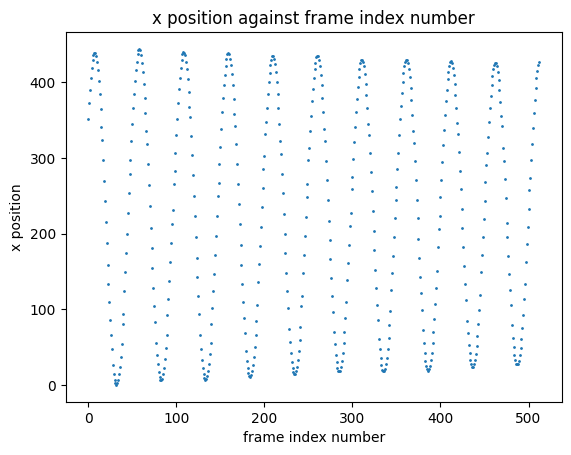

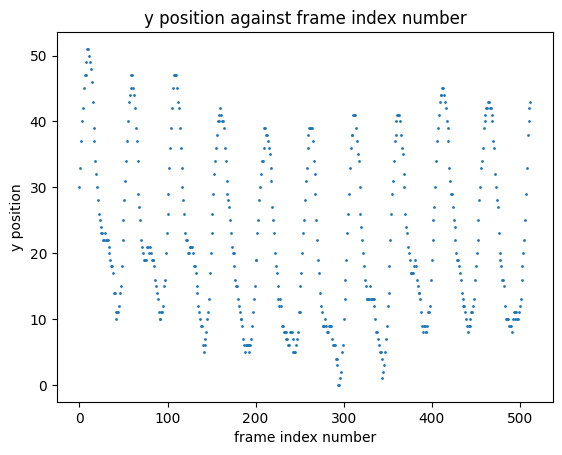

In [2]:
import matplotlib.pyplot as plt

plt.scatter(frame, x, s=1) #plot a scatter plot with x against frame with marker size 1
plt.xlabel("frame index number")
plt.ylabel("x position")
plt.title("x position against frame index number")
plt.show()
plt.scatter(frame, y, s=1) #plot a scatter plot with y against frame with marker size 1
plt.xlabel("frame index number")
plt.ylabel("y position")
plt.title("y position against frame index number")
plt.show()

# Try fitting

\begin{align}
\large x(t) = A \sin(2\pi f t + \alpha) + \text{offset}
\end{align}

#### We use the curve_fit function from the scipy library to find the values of A, f, $\alpha$, and  offset that fits the sine curve to our data the best.

A = 209.0915564605604, f = 0.5934359987864546, alpha = 0.6829631146352578, offset = 224.2087557487019


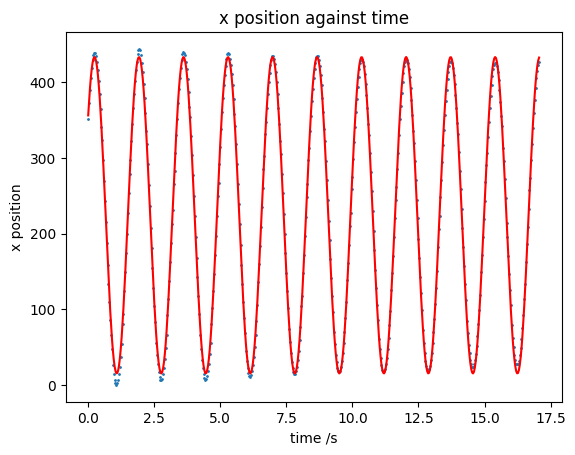

In [3]:
FPS = 30
t = frame / FPS #Assign each frame index to the number of seconds elapsed by dividing each frame by FPS

import numpy as np

def func(t, A, f, alpha, offset): #define function shown above as a function based on time, amplitude, frequency, x offset and y offset
    """ Returns x (horizontal position) as a function of time. Refer to pendulum equation above. """
    return A * np.sin(2 * np.pi * f * t + alpha) + offset



from scipy.optimize import curve_fit


popt, pcov = curve_fit(func, t, x, p0=[200, 9/15, np.pi/2, 250]) #obtain optimal values for amplitude, frequency, x offset and y offset using curve_fit
                                                                 #p0 is the initial guess for the parameters.
                                                                 #A ~= 450 - 250 = 200.
                                                                 #f ~= 9/15, because there are 9 full cycles within the first 15s of duration.
                                                                 #alpha looks to be a little smaller than pi/2, within the first quadrant.
                                                                 #offset ~= 250


print(f"A = {popt[0]}, f = {popt[1]}, alpha = {popt[2]}, offset = {popt[3]}") #we see that our initial guess is pretty close to curve_fit's results!
plt.scatter(t, x, s=1) #plotting a scatter plot with x against time with marker size 1
plt.plot(t, func(t, *popt), color="r", label="Best Fit") #plot best fit line using optimal values for the function
plt.xlabel("time /s")
plt.ylabel("x position")
plt.title("x position against time")
plt.show()


#### We can look at the r^2 value as an indicator of how well our model actually fits with our data.

In [4]:
from sklearn.metrics import r2_score

r2_score(x, func(t, *popt))

0.9982475997030593

#### This is a pretty darn good r^2 score I would say. But I think we can do even better, by taking into account resistive forces.

# An even better fit!

#### In real life, there are frictional forces acting on the pendulum taking energy away from it over time. An underdamped pendulum decays in amplitude exponentially​:

\begin{align} 
\large \theta_{max}(t) = \theta_{0} e^{-\frac{\eta}{2m} t}  
\end{align}

##### $ \eta $ : air drag constant ($ kg \cdot s^{-1} $)

#### So our improved model takes the following form: 


\begin{align} 
\large x(t) = x_{0}  e^{β t} sin(2πft + α) + \text{offset}
\end{align}


###### [don't believe me?](https://www.ippp.dur.ac.uk/~krauss/Lectures/NumericalMethods/Oscillator/Lecture/os4.html#:~:text=The%20underdamped%20regime%20In%20this,%2C%20Ω²%3Dg%2Fl.)

A = 220.22217546260714, f = 0.5934655789859307, alpha = 0.6816710671909416, offset = 224.05618597516704, beta = -0.0061789867795296475


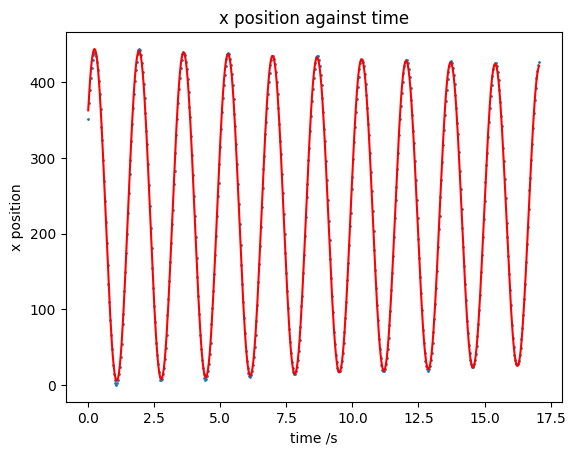

In [5]:
def func_damped(t, A, f, alpha, offset, beta): #define function shown above as a function based on time, amplitude, frequency, x offset, y offset and decay constant
    """ Returns x (horizontal position) as a function of time. Refer to damped pendulum equation above. """
    return A * np.exp(beta * t) * np.sin(2 * np.pi * f * t + alpha) + offset


popt_damped, pcov_damped = curve_fit(func_damped, t, x, p0=[200, 9/15, np.pi/2, 250, 0]) #obtain optimal values for amplitude, frequency, x offset, y offset and decay constant using curve_fit
print(f"A = {popt_damped[0]}, f = {popt_damped[1]}, alpha = {popt_damped[2]}, offset = {popt_damped[3]}, beta = {popt_damped[4]}") #we see that our initial guess is pretty close to curve_fit's results.

plt.scatter(t, x, s=1) #plotting a scatter plot with x against time with marker size 1
plt.plot(t, func_damped(t, *popt_damped), color="r", label="Best Fit") #plot best fit line using optimal values for the function
plt.xlabel("time /s")
plt.ylabel("x position")
plt.title("x position against time")
plt.show()

In [6]:
r2_score(x, func_damped(t, *popt_damped))

0.9991888873227992

#### An even nicer fit! We can visually compare that the damped-oscillator equation is able to account for the decaying amplitude of oscillation, which gives us a higher r^2 score.